### Step 1: Extract and clean unique ingredients
- Load the recipe dataset.
- Pick the **ingredient column** (English version).
- Clean the ingredient names (remove units, numbers, and punctuation).
- Collect all unique ingredient names.
- Save them into `unique_ingredients.csv`.


In [1]:
import pandas as pd
import re

# Load your dataset
df = pd.read_csv("IndianFoodDatasetCSV.csv")

# Choose the column with ingredients (English version for matching)
ingredient_col = "TranslatedIngredients"

# Function to clean ingredient strings
def clean_ingredient(ing):
    ing = ing.lower()
    ing = re.sub(r"\([^)]*\)", "", ing)  # remove text in parentheses
    ing = re.sub(r"[^a-z\s]", "", ing)   # remove numbers, punctuation
    ing = re.sub(r"\b(tsp|tbsp|cup|cups|grams|g|kg|ml|l|teaspoon|tablespoon)\b", "", ing)
    ing = re.sub(r"\s+", " ", ing).strip()
    return ing

# Split and clean
all_ingredients = []
for row in df[ingredient_col].dropna():
    for ing in row.split(","):
        cleaned = clean_ingredient(ing)
        if cleaned:
            all_ingredients.append(cleaned)

# Save unique ingredients to file
unique_ingredients = sorted(set(all_ingredients))
pd.Series(unique_ingredients).to_csv("unique_ingredients.csv", index=False, header=["Ingredient"])
print(f"Extracted {len(unique_ingredients)} unique ingredients.")

Extracted 11399 unique ingredients.


### Step 2: Categorize ingredients with fuzzy matching
- Normalize ingredient names (remove units, numbers, symbols).
- Load a **reference file (`02_Ingredients.csv`)** that contains ingredient categories and synonyms.
- Create a lookup dictionary for categories.
- Match each unique ingredient to a category using **fuzzy string matching** (to handle spelling differences).
- Save results to `categorized_ingredients.csv`.


In [4]:
import pandas as pd
import re
from rapidfuzz import process

# ---------- 1. Normalization function ----------
def normalize_name(name):
    if pd.isna(name):
        return ""
    name = name.lower()
    name = re.sub(r"\([^)]*\)", "", name)  # remove text in parentheses
    name = re.sub(r"\b\d+(\.\d+)?\b", "", name)  # remove numbers
    name = re.sub(r"\b(tsp|tbsp|cup|cups|grams|g|kg|ml|l|teaspoon|tablespoon|small|large|medium)\b", "", name)
    name = re.sub(r"[^a-z\s-]", "", name)  # keep only letters, spaces, hyphens
    name = re.sub(r"\s+", " ", name).strip()
    return name

# ---------- 2. Load category mapping ----------
cat_map = pd.read_csv("02_Ingredients.csv")

# Build expanded lookup dictionary
lookup = {}
for _, row in cat_map.iterrows():
    main_name = normalize_name(row["Aliased Ingredient Name"])
    if main_name:
        lookup[main_name] = row["Category"]

    for syn in str(row["Ingredient Synonyms"]).split(";"):
        syn = normalize_name(syn)
        if syn:
            lookup[syn] = row["Category"]

# ---------- 3. Load your unique ingredients ----------
# Assuming you already have unique_ingredients list from earlier extraction
ingredient_df = pd.DataFrame({"Ingredient": unique_ingredients})
ingredient_df["Normalized"] = ingredient_df["Ingredient"].apply(normalize_name)

# ---------- 4. Fuzzy match function ----------
def match_category(ingredient, lookup_dict, score_cutoff=80):
    if ingredient in lookup_dict:
        return lookup_dict[ingredient]
    match, score, _ = process.extractOne(ingredient, lookup_dict.keys())
    if match and score >= score_cutoff:
        return lookup_dict[match]
    return "Unknown"

# ---------- 5. Apply matching ----------
ingredient_df["Category"] = ingredient_df["Normalized"].apply(lambda x: match_category(x, lookup))

# ---------- 6. Save results ----------
ingredient_df.drop(columns=["Normalized"]).to_csv("categorized_ingredients.csv", index=False)

print(f"Categorized {len(ingredient_df)} ingredients. Unknown count: {(ingredient_df['Category'] == 'Unknown').sum()}")

Categorized 11399 ingredients. Unknown count: 795


### Step 3: Compute ingredient frequency and relevance
- Count how many times each ingredient appears in recipes.
- Compute **relevance score** = `1 / frequency` (rare ingredients are more relevant).
- Keep only ingredients that actually appear (frequency > 0)
- Save results:
  - `ingredient_relevance.csv` → frequency and relevance for all ingredients.
  - `top_relevant_per_category.csv` → top category.


In [10]:
import pandas as pd
from collections import Counter
import re

# ---------- 1. Normalization ----------
def normalize_name(name):
    if pd.isna(name):
        return ""
    name = name.lower()
    name = re.sub(r"\([^)]*\)", "", name)  # remove parentheses
    name = re.sub(r"\b\d+(\.\d+)?\b", "", name)  # remove numbers
    name = re.sub(r"\b(tsp|tbsp|cup|cups|grams|g|kg|ml|l|teaspoon|tablespoon|small|large|medium)\b", "", name)
    name = re.sub(r"[^a-z\s-]", "", name)  # keep only letters, spaces, hyphens
    name = re.sub(r"\s+", " ", name).strip()
    return name

# ---------- 2. Load recipe dataset ----------
df = pd.read_csv("IndianFoodDatasetCSV.csv")
ingredient_col = "TranslatedIngredients"  # adjust if needed

# Parse and normalize all ingredients from recipes
all_ingredients = []
for row in df[ingredient_col].dropna():
    for ing in row.split(","):
        cleaned = normalize_name(ing)
        if cleaned:
            all_ingredients.append(cleaned)

# ---------- 3. Load categorized ingredients ----------
cat_df = pd.read_csv("categorized_ingredients.csv")

# ---------- 4. Count frequency ----------
freq_counter = Counter(all_ingredients)
cat_df["Frequency"] = cat_df["Ingredient"].map(freq_counter).fillna(0).astype(int)

# ---------- 5. Compute relevance ----------
cat_df["Relevance"] = cat_df["Frequency"].apply(lambda f: 1/f if f > 0 else 0)

# ---------- 6. Filter out zero-frequency ingredients ----------
cat_df_nonzero = cat_df[cat_df["Frequency"] > 0].copy()

# ---------- 7. Find top N relevant ingredients per category ----------
N = 5
top_per_category = (
    cat_df_nonzero[cat_df_nonzero["Category"] != "Unknown"]
    .sort_values(["Category", "Relevance"], ascending=[True, False])
    .groupby("Category")
    .head(N)
)

# ---------- 8. Save outputs ----------
cat_df_nonzero.to_csv("ingredient_relevance.csv", index=False)
top_per_category.to_csv("top_relevant_per_category.csv", index=False)

print("Saved:")
print(" - ingredient_relevance.csv (only ingredients with frequency > 0)")
print(f" - top_relevant_per_category.csv (top {N} per category)")

Saved:
 - ingredient_relevance.csv (only ingredients with frequency > 0)
 - top_relevant_per_category.csv (top 5 per category)


### Step 4: Rank ingredient categories by relevance
- Load ingredient relevance results.
- Remove the "Unknown" category.
- Compute **median relevance per category** (so categories with rarer ingredients rank higher).
- Rank all categories and assign labels:
  - High relevance → rare ingredients
  - Low relevance → common ingredients
- Save ranking to `category_relevance_ranking.csv`.


In [12]:
import pandas as pd

# Load the full relevance data
df = pd.read_csv("ingredient_relevance.csv")

# Drop Unknown category if you want cleaner results
df = df[df["Category"] != "Unknown"]

# Compute median relevance per category
category_stats = (
    df.groupby("Category")["Relevance"]
      .median()
      .reset_index()
      .sort_values("Relevance", ascending=False)
)

# Assign rank
category_stats["Rank"] = range(1, len(category_stats) + 1)

# Optional: qualitative labels
def label_relevance(val, q1, q3):
    if val >= q3:
        return "High relevance (rare ingredients)"
    elif val <= q1:
        return "Low relevance (common ingredients)"
    else:
        return "Medium relevance"

q1 = category_stats["Relevance"].quantile(0.25)
q3 = category_stats["Relevance"].quantile(0.75)
category_stats["Relevance_Label"] = category_stats["Relevance"].apply(lambda x: label_relevance(x, q1, q3))

# Save and print
category_stats.to_csv("category_relevance_ranking.csv", index=False)

print("Category Relevance Ranking:")
for _, row in category_stats.iterrows():
    print(f"{row['Rank']}. {row['Category']}: median relevance {row['Relevance']:.3f} → {row['Relevance_Label']}")

Category Relevance Ranking:
1. Beverage Alcoholic: median relevance 1.000 → High relevance (rare ingredients)
2. Fish: median relevance 1.000 → High relevance (rare ingredients)
3. Seafood: median relevance 1.000 → High relevance (rare ingredients)
4. Dish: median relevance 1.000 → High relevance (rare ingredients)
5. Additive: median relevance 0.500 → High relevance (rare ingredients)
6. Cereal: median relevance 0.500 → High relevance (rare ingredients)
7. Beverage: median relevance 0.500 → High relevance (rare ingredients)
8. Bakery: median relevance 0.500 → High relevance (rare ingredients)
9. Dairy: median relevance 0.500 → High relevance (rare ingredients)
10. Fruit: median relevance 0.500 → High relevance (rare ingredients)
11. Fungus: median relevance 0.500 → High relevance (rare ingredients)
12. Legume: median relevance 0.500 → High relevance (rare ingredients)
13. Essential Oil: median relevance 0.500 → High relevance (rare ingredients)
14. Plant: median relevance 0.500 → High

### Step 5: Visualize category relevance
- Load ingredient relevance and top ingredients per category.
- Plot **boxplots** of ingredient relevance for each category.
- Sort categories by median relevance.
- Annotate:
  - Red rank numbers → category rank.
  - Blue text → top ingredient in each category.
- This gives a clear comparison of relevance distributions across categories.


C:\Users\Adity\AppData\Local\Temp\ipykernel_2640\2478911784.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


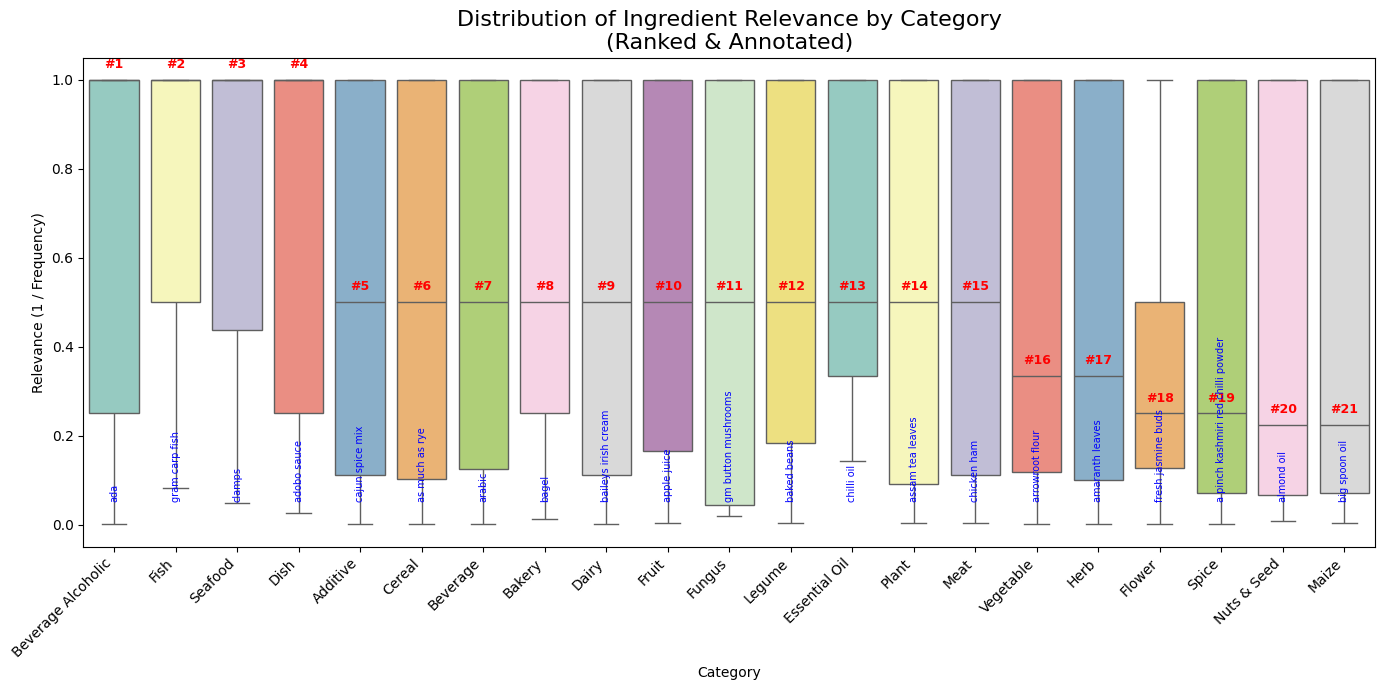

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Load data ----------
relevance_df = pd.read_csv("ingredient_relevance.csv")
top_ing_df = pd.read_csv("top_relevant_per_category.csv")

# Drop Unknown category for clarity
relevance_df = relevance_df[relevance_df["Category"] != "Unknown"]

# ---------- 2. Sort categories by median relevance ----------
category_order = (
    relevance_df.groupby("Category")["Relevance"]
    .median()
    .sort_values(ascending=False)
    .index
)

# ---------- 3. Calculate median relevance per category ----------
medians = relevance_df.groupby("Category")["Relevance"].median().reindex(category_order)

# ---------- 4. Prepare top ingredient lookup ----------
top_ing_lookup = (
    top_ing_df.groupby("Category")["Ingredient"]
    .first()
    .to_dict()
)

# ---------- 5. Plot boxplot ----------
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=relevance_df,
    x="Category",
    y="Relevance",
    order=category_order,
    showfliers=False,
    palette="Set3"
)

# ---------- 6. Overlay rank numbers ----------
for i, (cat, val) in enumerate(medians.items()):
    plt.text(i, val + 0.02, f"#{i+1}", ha="center", va="bottom",
             fontsize=9, fontweight="bold", color="red")

# ---------- 7. Annotate top ingredient names ----------
for i, cat in enumerate(category_order):
    if cat in top_ing_lookup:
        plt.text(i, 0.05, top_ing_lookup[cat],
                 ha="center", va="bottom", fontsize=7,
                 rotation=90, color="blue")

# ---------- 8. Final touches ----------
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Ingredient Relevance by Category\n(Ranked & Annotated)", fontsize=16)
plt.ylabel("Relevance (1 / Frequency)")
plt.xlabel("Category")
plt.tight_layout()
plt.show()